### **A nueral network implementation of maternal health classification**

### Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Load the dataset and understand the dataset

In [4]:
# Load the dataset
file_path = '../input/maternal-health-risk-data/Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)

In [5]:
# Display the first few rows to understand the data
print(data.head())

   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk


In [6]:
# Separate features and target variable
X = data.drop(columns=['RiskLevel'])
y = data['RiskLevel']

In [7]:
df=data.copy()

In [8]:
df = df.drop_duplicates().reset_index(drop=True)

In [9]:
df.shape

(452, 7)

In [10]:
df.replace({"high risk":2, "mid risk":1, "low risk":0}, inplace=True)
df.head()

/tmp/ipykernel_30/247815498.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({"high risk":2, "mid risk":1, "low risk":0}, inplace=True)


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0


Text(0.5, 1.0, 'Age by Risk Level')

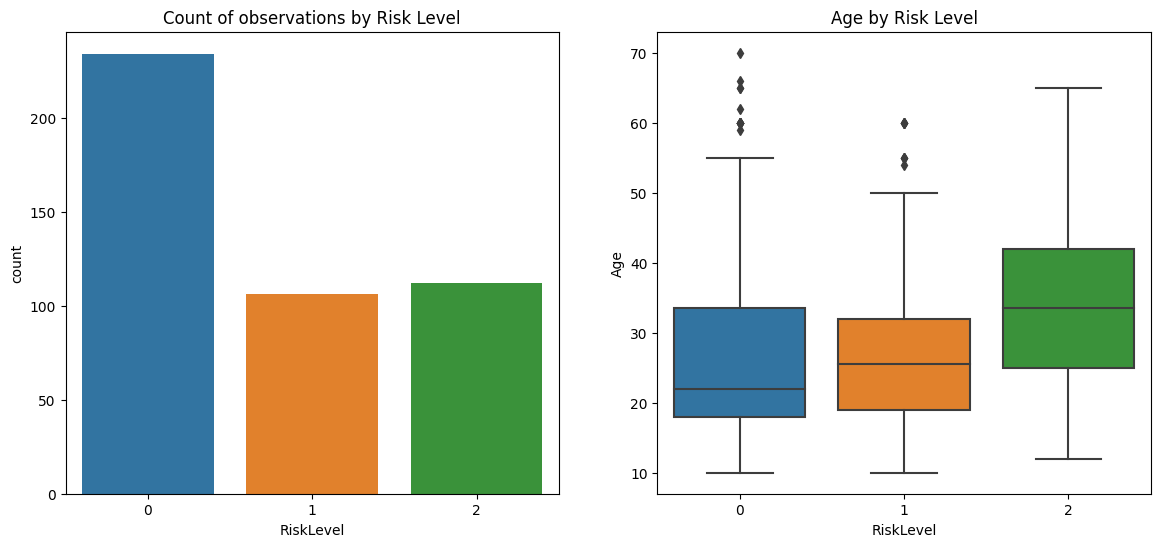

In [11]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.countplot(ax=axes[0], x=df.RiskLevel)
axes[0].set_title("Count of observations by Risk Level")

sns.boxplot(ax=axes[1], x=df.RiskLevel, y=df.Age)
axes[1].set_title("Age by Risk Level")

Text(0.5, 1.0, 'Blood Glucose by Risk Level')

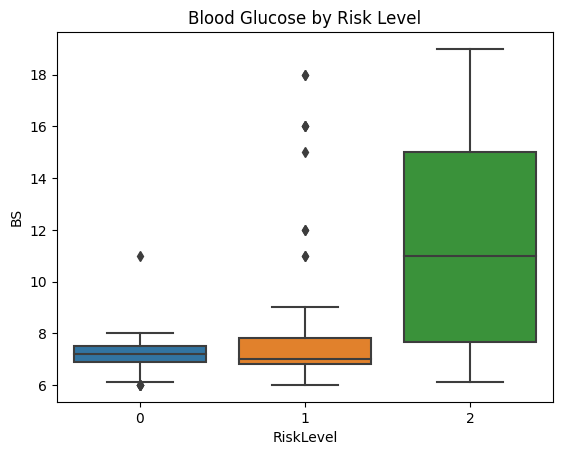

In [12]:
sns.boxplot(x=df.RiskLevel, y=df.BS).set_title("Blood Glucose by Risk Level")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Distribution of Upper value of Blood Pressure, mmHg')

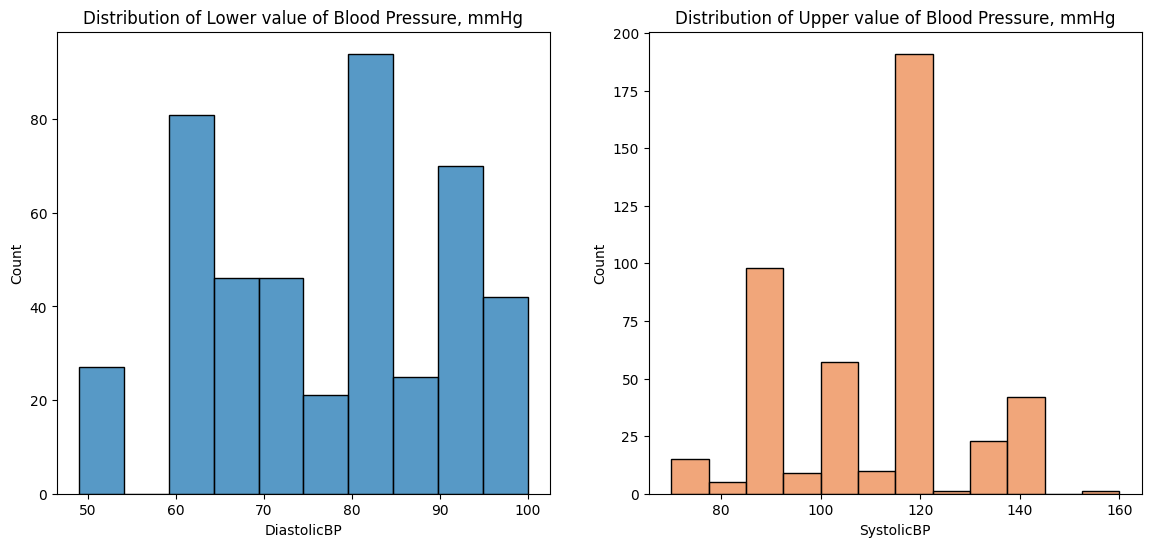

In [13]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.histplot(ax=axes[0], x=df.DiastolicBP)
axes[0].set_title("Distribution of Lower value of Blood Pressure, mmHg")

sns.histplot(ax=axes[1], x=df.SystolicBP, color="#ed894e")
axes[1].set_title("Distribution of Upper value of Blood Pressure, mmHg")

Text(0.5, 1.0, 'Upper value of Blood Pressure by Risk Level')

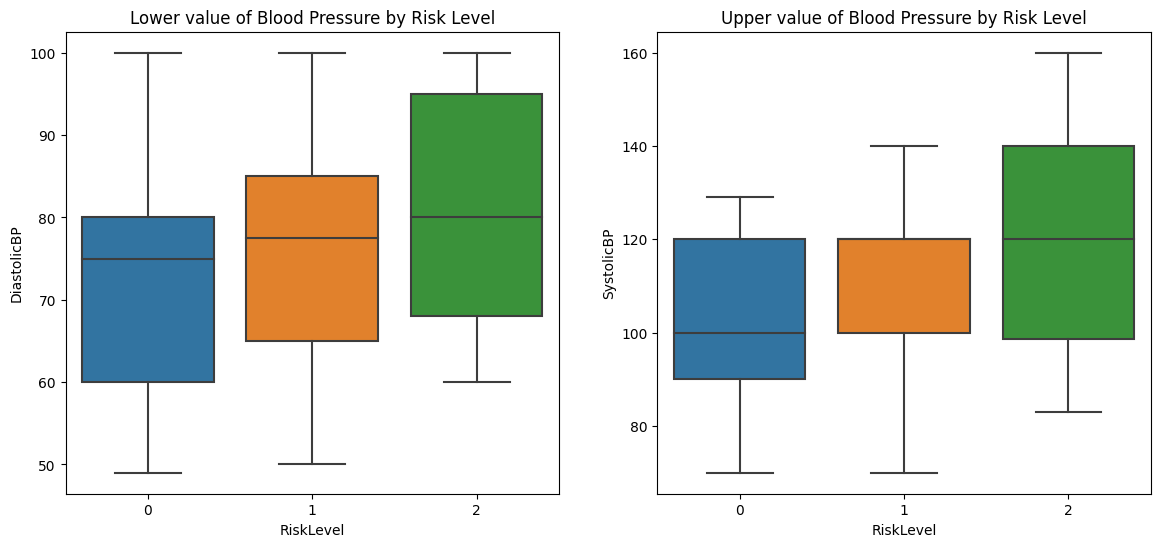

In [14]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.boxplot(ax=axes[0], x=df.RiskLevel, y=df.DiastolicBP)
axes[0].set_title("Lower value of Blood Pressure by Risk Level")

sns.boxplot(ax=axes[1], x=df.RiskLevel, y=df.SystolicBP)
axes[1].set_title("Upper value of Blood Pressure by Risk Level")

Text(0.5, 1.0, 'Upper value of Blood Pressure VS Age')

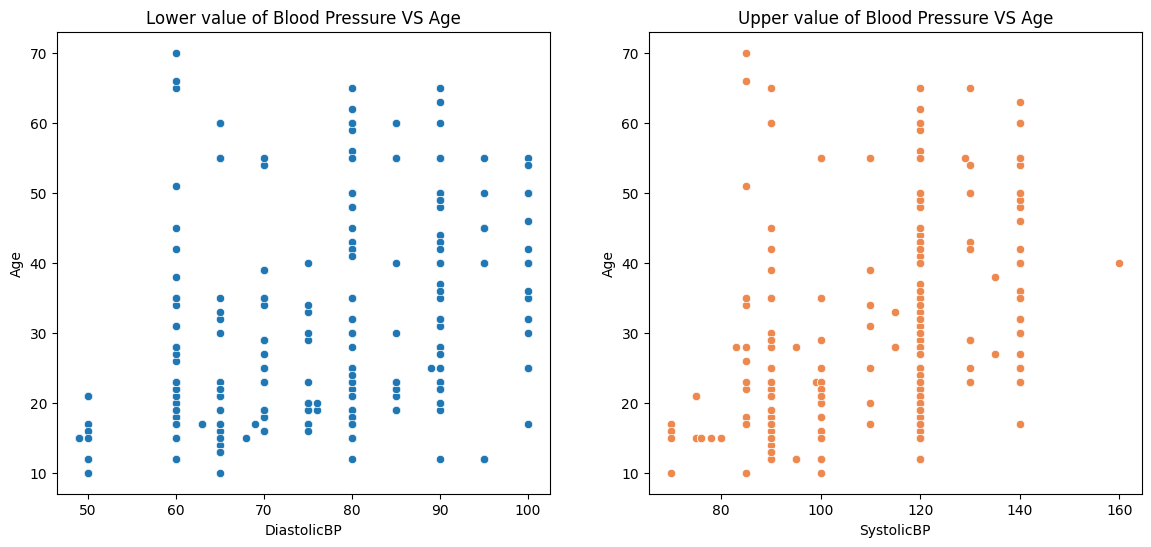

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.scatterplot(x=df.DiastolicBP, y=df.Age, ax=axes[0])
axes[0].set_title("Lower value of Blood Pressure VS Age")

sns.scatterplot(ax=axes[1], x=df.SystolicBP, y=df.Age, color="#ed894e")
axes[1].set_title("Upper value of Blood Pressure VS Age")

Text(0.5, 1.0, 'Body Temperature by Risk Level')

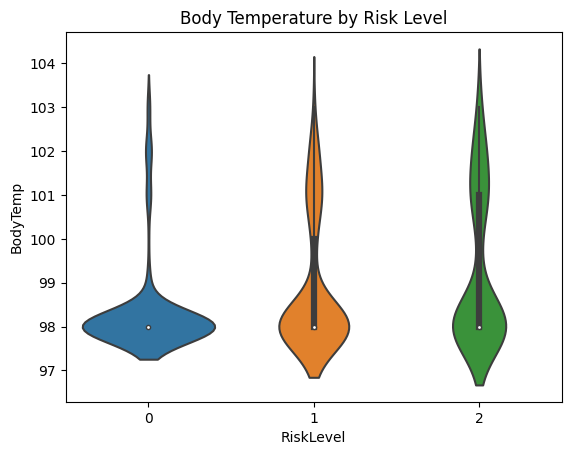

In [16]:
sns.violinplot(y=df.BodyTemp, x=df.RiskLevel).set_title("Body Temperature by Risk Level")

In [18]:
df.HeartRate.mode()

0    70
Name: HeartRate, dtype: int64

In [19]:
df.loc[df.HeartRate == 7, "HeartRate"] = 70

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Heart Rate by Risk Level')

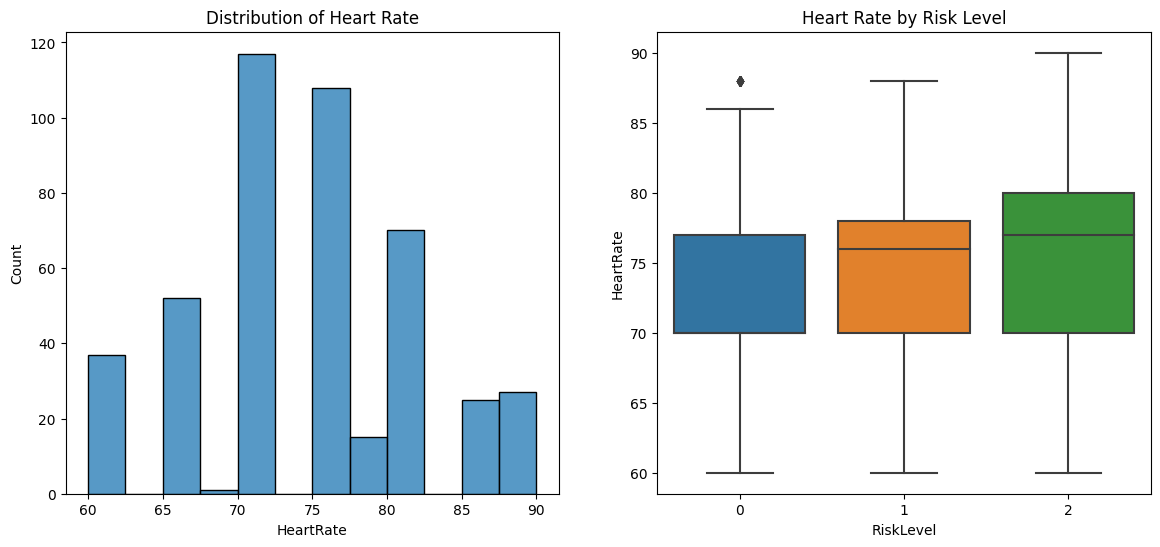

In [20]:
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(14,6))

sns.histplot(ax=axes[0], x=df.HeartRate)
axes[0].set_title("Distribution of Heart Rate")

sns.boxplot(ax=axes[1], x=df.RiskLevel, y=df.HeartRate)
axes[1].set_title("Heart Rate by Risk Level")

### Observations from visualizations above:
- The **low risk pregnancies** are the most frequent overall, they happen in more than half of the cases.
- Younger women tend to have **low** and **mid** risk pregnancies, while the pregnancies of women above 35 y.o. more often are classified as **high** risk, thus, need more attention.
- If a pregnant woman has a **blood sugar** higher than 8 mmol/L, in most of the cases, the pregnancy is considered high risk.
- Distribution of lower value of **blood pressure** is more spread, around 60-100 mmHg, compared to distribution of upper value, which is centered around 120 mmHg.
- Higher **blood pressure** (both systolic and diastolic), higher **body temperature** are associated with **higher risk** pregnancies.
- As for correlation between age and blood pressure, very low blood pressure (both systolic and diastolic) was observed in some of the girls and young women, but normal and high blood pressure don't seem to be much correlated with age, at least in our dataset.
- Heart rate of pregnant women is **normally distributed** and it's only slightly associated with risk level.

### Encode the target variable and split the dataset

In [22]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'RiskLevel' to numeric values
y_categorical = to_categorical(y_encoded)    # Converts numeric labels to one-hot encoding

In [23]:
# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [24]:
# Standardize the features (important for neural networks)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [25]:
# Define a more complex model with dropout layers to avoid overfitting
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Another dropout layer
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 output classes (high, medium, low risk)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile and train the model for 100 epochs

In [26]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Implement early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [28]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping])

Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.3607 - loss: 1.0983 - val_accuracy: 0.5583 - val_loss: 1.0348
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5452 - loss: 1.0179 - val_accuracy: 0.5890 - val_loss: 0.9618
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5552 - loss: 0.9469 - val_accuracy: 0.6012 - val_loss: 0.8766
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5985 - loss: 0.8963 - val_accuracy: 0.6626 - val_loss: 0.8280
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5683 - loss: 0.8628 - val_accuracy: 0.6626 - val_loss: 0.7958
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6298 - loss: 0.8180 - val_accuracy: 0.6564 - val_loss: 0.7859
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6162 - loss: 0.8498 - val_accuracy: 0.6503 - val_loss: 0.7713
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6394 - loss: 0.7655 - val_accuracy: 0.6380 - 

### Evaluvate the model

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")
# Generate predictions and decode them
y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)
y_true_labels = y_test.argmax(axis=1)

Test Accuracy: 0.67
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [30]:
# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

   high risk       0.76      0.87      0.81        47
    low risk       0.61      0.85      0.71        80
    mid risk       0.73      0.36      0.48        76

    accuracy                           0.67       203
   macro avg       0.70      0.69      0.67       203
weighted avg       0.69      0.67      0.65       203



### Display the normalized confusion matrix 

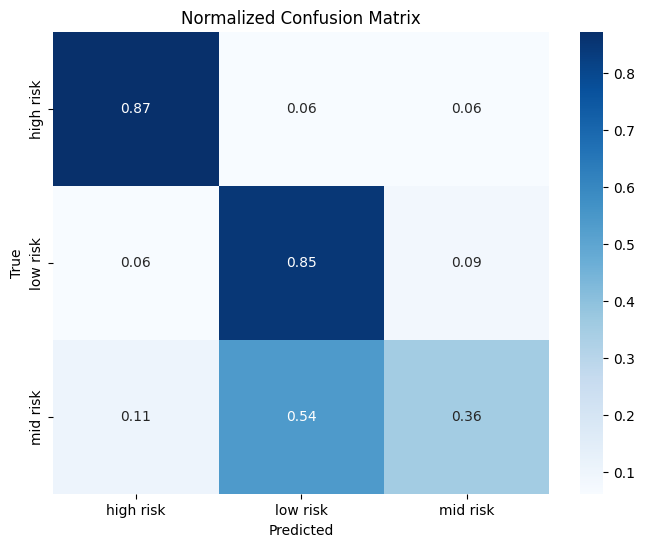

In [31]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Normalize by row (true class) - each row sums to 1
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plotting the normalized confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()